In [ ]:
# Last run at d94de94

In [1]:
import csv
import os
import numpy

In [2]:
mibig_structures = "/home/grimur/_iokr/data/mibig/compunds_structures_1.4.csv"

bgc_structures = {}

with open(mibig_structures) as f:
    r = csv.reader(f)
    header = next(r)
    for line in r:
        bgc_id, bgc_name, smiles, pubchem = line
    
        if smiles.strip() == "":
            continue

        if bgc_id in bgc_structures:
            bgc_structures[bgc_id].append(smiles)
        else:
            bgc_structures[bgc_id] = [smiles]        


In [3]:
import sys
sys.path.append('/home/grimur/git/nplinker/nplinker/prototype')
from nplinker.scoring.iokr import mk_fprints

['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [13]:
smiles_fingerprints = {}
for bgc, smiles_list in bgc_structures.items():
    for smiles in smiles_list:
        if smiles not in smiles_fingerprints:
            fp = mk_fprints.fingerprint_from_smiles(smiles)
            smiles_fingerprints[smiles] = fp

In [4]:
import numpy

def fp_vector_kernel(v1, v2):
    v1 = v1.astype('bool')
    v2 = v2.astype('bool')
    tanimoto_or = numpy.count_nonzero(numpy.logical_or(v1, v2))
    tanimoto_and = numpy.count_nonzero(numpy.logical_and(v1, v2))
    if tanimoto_and is 0:
        tanimoto = 0
    else: 
        tanimoto = tanimoto_or / tanimoto_and
    return gaussian(tanimoto ** 2)

def l2_gaussian(v1, v2, gamma=0.01):
    d_sq = numpy.sum(numpy.power(v1 - v2, 2))
    return gaussian(d_sq, gamma)

def gaussian(x, gamma=0.01):
    return numpy.exp(-(gamma * x))

def pfam_vector_kernel(v1, v2):
    return l2_gaussian(numpy.array(v1), numpy.array(v2))



In [24]:
def read_bgc_ids(product_type):
    # read the BiG-SCAPE file to harvest BGC IDs for the product type
    bigscape_file = "/home/grimur/mibig_kernel_test/network_files/2020-05-20_13-07-27_hybrids_glocal/{}/{}_c0.90.network"
    bgc_id_list = []
    with open(bigscape_file.format(product_type, product_type)) as f:
        #print(next(f))
        for line in f.readlines():
            fields = line.split()
            bgc_1 = fields[0].split('.')[0]
            bgc_2 = fields[1].split('.')[0]
            if bgc_1 in bgc_structures.keys() and bgc_1 not in bgc_id_list:
                bgc_id_list.append(bgc_1)
            if bgc_2 in bgc_structures.keys() and bgc_2 not in bgc_id_list:
                bgc_id_list.append(bgc_2)
    return bgc_id_list

In [54]:
def get_fingerprint_matrix(bgc_list, expand=False):
    fp_list = []
    
    if expand:
        print('expand')
        bgc_id_list = []
        smiles_list = []
        for bgc_id in bgc_list:
            for smiles in bgc_structures[bgc_id]:
                bgc_id_list.append(bgc_id)
                smiles_list.append(smiles)
                fp_list.append(smiles_fingerprints[smiles])
        bgc_count = len(bgc_id_list)
        fingerprint_matrix = numpy.zeros((bgc_count, bgc_count))
        for i in range(bgc_count):
            for j in range(i + 1):
                v1 = smiles_fingerprints[smiles_list[i]]
                v2 = smiles_fingerprints[smiles_list[j]]
                dist = fp_vector_kernel(v1, v2)
                fingerprint_matrix[i, j] = dist
                fingerprint_matrix[j, i] = dist
    else:
        print('max')
        bgc_id_list = bgc_list
        bgc_count = len(bgc_id_list)
        fingerprint_matrix = numpy.zeros((bgc_count, bgc_count))
        for i in range(bgc_count):
            for j in range(i + 1):
                bgc_id_1 = bgc_id_list[i]
                bgc_id_2 = bgc_id_list[j]
                fp_kern = 10000
                for smiles_1 in bgc_structures[bgc_id_1]:
                    for smiles_2 in bgc_structures[bgc_id_2]:
                        # Choose the best possible match, because the identical bgcs encoding for two distinct products
                        # might get a bad score otherwise, and that wouldn't make sense
                        # BUT! This may destroy the kernel properties!!!
                        fp1 = smiles_fingerprints[smiles_1]
                        fp2 = smiles_fingerprints[smiles_2]
                        fp_kern = min(fp_vector_kernel(fp1, fp2), fp_kern)
                fingerprint_matrix[i, j] = fp_kern
                fingerprint_matrix[j, i] = fp_kern

    return fingerprint_matrix, bgc_id_list, fp_list, smiles_list

In [256]:
def get_bgc_matrices(bgc_id_list, product_type, fp_matrix):
    # the fp_matrix is included as a target for the mkl alignment stuff!
    
    # pfam word vector metric
    # big-scape metric
    # kernelised big-scape (clip)
    # kernelised big-scape (flip)
    # re-calibrated big-scape (clip)
    # re-calibrated big-scape (flip)

    bigscape_file = "/home/grimur/mibig_kernel_test/network_files/2020-05-20_13-07-27_hybrids_glocal/{}/{}_c0.90.network"
    #bigscape_distance_matrix = -1.0 * numpy.ones((len(bgc_id_list), len(bgc_id_list))) + 2.0 * numpy.eye(len(bgc_id_list))
    bigscape_distance_matrix = numpy.zeros((len(bgc_id_list), len(bgc_id_list)))
    bigscape_jaccard_matrix = numpy.zeros((len(bgc_id_list), len(bgc_id_list)))
    bigscape_dss_matrix = numpy.zeros((len(bgc_id_list), len(bgc_id_list)))
    bigscape_ai_matrix = numpy.zeros((len(bgc_id_list), len(bgc_id_list)))

    # jaccard index -- dss index -- adjacency index -- anchorboost
    # Distance = 1 - (Jaccardw * Jaccard) - (DSSw * DSS) - (AIw * AI)

    with open(bigscape_file.format(product_type, product_type)) as f:
        #print(next(f))
        for line in f.readlines():
            fields = line.split()
            bgc_1 = fields[0].split('.')[0]
            bgc_2 = fields[1].split('.')[0]

            try:
                idx1 = bgc_id_list.index(bgc_1)
                idx2 = bgc_id_list.index(bgc_2)
            except ValueError:
                continue

            # bigscape stuff
            distance = fields[2]
            similarity = fields[3]
            jaccard = fields[4]
            dss = fields[5]
            ai = fields[6]

            #bigscape_distance_matrix[idx1, idx2] = float(distance)
            #bigscape_distance_matrix[idx2, idx1] = float(distance)
            bigscape_distance_matrix[idx1, idx2] = float(similarity)
            bigscape_distance_matrix[idx2, idx1] = float(similarity)
            bigscape_jaccard_matrix[idx1, idx2] = float(jaccard)
            bigscape_jaccard_matrix[idx2, idx1] = float(jaccard)
            bigscape_dss_matrix[idx1, idx2] = float(dss)
            bigscape_dss_matrix[idx2, idx1] = float(dss)
            bigscape_ai_matrix[idx1, idx2] = float(ai)
            bigscape_ai_matrix[idx2, idx1] = float(ai)

    bigscape_distance_matrix[bigscape_distance_matrix == -1] = numpy.max(bigscape_distance_matrix)
            
    yield 'bigscape', bigscape_distance_matrix
    yield 'bigscape_clip', kernelise_clip(bigscape_distance_matrix)
    yield 'bigscape_flip', kernelise_flip(bigscape_distance_matrix)
    
    bigscape_weights = {
        "PKSI": (0.22, 0.76, 0.02),
        "PKSother": (0.0, 0.32, 0.68),
        "NRPS": (0.0, 1.0, 0.0),
        "RiPPs": (0.28, 0.71, 0.01),
        "Saccharides": (0.0, 0.0, 1.0),
        "Terpene": (0.2, 0.75, 0.05),
        "PKS-NRP_Hybrids": (0.0, 0.78, 0.22),
        "Others": (0.01, 0.97, 0.02),
        "mix": (0.2, 0.75, 0.05)
    }
    
    j_wt, dss_wt, ai_wt = bigscape_weights[product_type]

    bigscape_reconstructed = j_wt * bigscape_jaccard_matrix + dss_wt * bigscape_dss_matrix + ai_wt * bigscape_ai_matrix
    yield 'bigscape_reconstructed', bigscape_reconstructed
    yield 'bigscape_reconstructed_clip', kernelise_clip(bigscape_reconstructed)
    yield 'bigscape_reconstructed_flip', kernelise_flip(bigscape_reconstructed)    
    
    pfam_kernel_matrix, tfidf_kernel_matrix = build_pfam_wv_matrix(bgc_id_list)
    yield 'pfam_wv', pfam_kernel_matrix
    yield 'tfidf_wv',  tfidf_kernel_matrix
    
    jaccard_clip = center_kernel(kernelise_clip(bigscape_jaccard_matrix))
    dss_clip = center_kernel(kernelise_clip(bigscape_dss_matrix))
    ai_clip = center_kernel(kernelise_clip(bigscape_ai_matrix))
    fp_clip = center_kernel(kernelise_clip(fp_matrix))
    yield 'bigscape_uncalibrated_clip', j_wt * jaccard_clip + dss_wt * dss_clip + ai_wt * ai_clip
    yield 'bigscape_recalibrated_clip', mkl_align(fp_clip, jaccard_clip, dss_clip, ai_clip)
    
    jaccard_flip = center_kernel(kernelise_flip(bigscape_jaccard_matrix))
    dss_flip = center_kernel(kernelise_flip(bigscape_dss_matrix))
    ai_flip = center_kernel(kernelise_flip(bigscape_ai_matrix))
    fp_flip = center_kernel(kernelise_flip(fp_matrix))
    yield 'bigscape_uncalibrated_flip', j_wt * jaccard_flip + dss_wt * dss_clip + ai_wt * ai_clip
    yield 'bigscape_recalibrated_flip', mkl_align(fp_flip, jaccard_flip, dss_flip, ai_flip)
    #yield kernel_type, kernel_matrix

In [214]:
def kernelise_clip(matrix):
    eigvals, eigvecs = linalg.eig(matrix)
    # reconstruct
    # Note row vs. col eigenvectors!
    # numpy.dot(numpy.dot(eigvecs, numpy.diag(eigvals)), eigvecs.T)
    
    # Should be the case, but you never know. May as well nip it in the bud.
    eigvals = numpy.real(eigvals)
    clip_eigvals = numpy.clip(eigvals, a_min=0, a_max=None)

    reconstructed = numpy.dot(numpy.dot(eigvecs, numpy.diag(clip_eigvals)), eigvecs.T)
    
    # Let's not assume... (supposed to be real, anyway)
    return numpy.real(reconstructed)

def kernelise_flip(matrix):
    eigvals, eigvecs = linalg.eig(matrix)
    # reconstruct
    # Note row vs. col eigenvectors!
    # numpy.dot(numpy.dot(eigvecs, numpy.diag(eigvals)), eigvecs.T)
    
    # Should be the case, but you never know. May as well nip it in the bud.
    eigvals = numpy.real(eigvals)
    abs_eigvals = numpy.abs(eigvals)

    reconstructed = numpy.dot(numpy.dot(eigvecs, numpy.diag(abs_eigvals)), eigvecs.T)
    
    # Let's not assume... (supposed to be real, anyway)
    return numpy.real(reconstructed)

In [215]:
from sklearn.preprocessing import KernelCenterer
from numpy import linalg
from qpsolvers import solve_qp

In [216]:


def center_kernel(K):
    t = KernelCenterer()
    return t.fit_transform(K)

# Frobenius product of two matrices
def frobenius_product(A, B):
    return numpy.dot(A.T, B).trace()
    
# Sanity check. Should be 21, acc. to Wikipedia :)
A = numpy.array([[2, 0, 6],
                [1, -1, 2]])
B = numpy.array([[8, -3, 2],
                [4, 1, -5]])
print(frobenius_product(A, B))


def frobenius_norm(A):
    return numpy.sqrt(frobenius_product(A, A))

def a_vec(kernel_matrices, target_kernel):
    return numpy.array([frobenius_product(k, target_kernel) for k in kernel_matrices])
    
def M_mat(kernel_matrices):
    M = numpy.zeros((len(kernel_matrices), len(kernel_matrices)))
    for i in range(len(kernel_matrices)):
        for j in range(i + 1):
            prod = frobenius_product(kernel_matrices[i], kernel_matrices[j])
            M[i, j] = prod
            M[j, i] = prod
    return M

# the actual heavy lifting
def mkl_align(target, *mat):
    # assume the matrices are centered and kernelised!
    ker_components = mat
    ker_target = target

    a = a_vec(ker_components, ker_target)
    M = M_mat(ker_components)
    
    # Use QP solver to solve
    #  min_{v > 0} v' M v - 2 v' a
    # with
    #  a = (<K_1c, yy'>, <K_2c, yy'>, ...)
    #  M_kl = <K_kc, K_lc>
    # and yy' the target kernel matrix
    sol = solve_qp(M, -a, lb=numpy.array([0.0, 0.0, 0.0]))
    sol = sol / numpy.sum(sol)
    
    print(sol)
    # return the composite matrix
    return sum([a * b for a, b in zip(sol, ker_components)])

21


In [217]:
# Build a set of equivalence classes
# bgc_structures -- bgc -> smiles
# structure_bgcs -- smiles -> bgc
structure_bgcs = {}
for bgc_id, structures in bgc_structures.items():
    for structure in structures:
        if structure in structure_bgcs:
            structure_bgcs[structure].append(bgc_id)
        else:
            structure_bgcs[structure] = [bgc_id]
            
def randomise_cv_folds(iokr_bgc_id_list, num_folds=10):
    iokr_folds = numpy.ones_like(iokr_bgc_id_list, dtype='int') * -1

    for bgc_idx in range(len(iokr_folds)):
        #print(bgc_idx)
        if iokr_folds[bgc_idx] != -1:
            continue
        bgc_id = iokr_bgc_id_list[bgc_idx]
        label = numpy.random.randint(num_folds)

        iokr_folds[bgc_idx] = label
        changed = True
        while changed == True:
            changed = False
            for bgc_change_idx in numpy.where(iokr_folds == label)[0]:
                bgc_change_id = iokr_bgc_id_list[bgc_change_idx]
                for smiles in bgc_structures[bgc_change_id]:
                    for bgc_subchange_id in structure_bgcs[smiles]:
                        for bgc_label_idx in numpy.where(numpy.array(iokr_bgc_id_list) == bgc_subchange_id)[0]:
                            if iokr_folds[bgc_label_idx] == -1:
                                #print('reset changed')
                                changed = True
                                iokr_folds[bgc_label_idx] = label
                                
    return iokr_folds


In [218]:
def run_iokr_test(dataserver, bgc_kernel_matrix, candidate_fp_list, cv_folds):
    cv_correct_ranks = []
    cv_incorrect_ranks = []
    
    for cv_label in set(cv_folds):
        print('split data set')
        training_samples = numpy.where(cv_folds != cv_label)[0]
        test_samples = numpy.where(cv_folds == cv_label)[0]

        print('iokr fit')
        iokr = iokr_opt.InputOutputKernelRegression(dataserver)
        iokr.set_training_indices(indices=training_samples)
        iokr.fit()

        print('preprocess')
        latent, latent_basis, gamma = iokr.get_data_for_novel_candidate_ranking()
        candidates = iokr_opt.preprocess_candidates(candidate_fp_list, latent, latent_basis, gamma)

        print('preprocess_fp')
        preprocessed_fingerprints = iokr_opt.preprocess_project_candidates(numpy.array(latent), numpy.array(candidate_fp_list), latent_basis, gamma)

        print('test')
        for j in test_samples:
            kernel_vector = bgc_kernel_matrix[training_samples, j]
            ranks = iokr_opt.rank_candidates_preprocessed_fingerprints(preprocessed_fingerprints, kernel_vector)
            correct_rank = numpy.min(numpy.where(ranks == j))
            cv_correct_ranks.append(correct_rank)

            numpy.random.shuffle(ranks)
            incorrect_rank = numpy.min(numpy.where(ranks == j))
            cv_incorrect_ranks.append(incorrect_rank)

    return cv_correct_ranks, cv_incorrect_ranks

In [219]:
def build_pfam_wv_matrix(bgc_id_list):
    pfs_dir = "/home/grimur/mibig_kernel_test/cache/pfs"
    
    num_documents = 0
    lexicon_count = {}
    for filename in os.listdir(pfs_dir):
        if filename.endswith('.pfs'):
            with open(pfs_dir + os.sep + filename) as f:
                data = set([x.split('.')[0] for x in f.read().split()])
                num_documents += 1
                for word in data:
                    if word in lexicon_count:
                        lexicon_count[word] += 1
                    else:
                        lexicon_count[word] = 1
    
    word_list = list(lexicon_count.keys())
    
    word_matrix = numpy.zeros((len(bgc_id_list), len(word_list)))
    tfidf_matrix = numpy.zeros((len(bgc_id_list), len(word_list)))
    for bgc_idx, bgc_id in enumerate(bgc_id_list):
        with open(pfs_dir + os.sep + bgc_id + '.1.pfs') as f:
            data = [x.split('.')[0] for x in f.read().split()]
            for word_idx, word in enumerate(word_list):
                word_count = data.count(word)
                word_matrix[bgc_idx, word_idx] = word_count
                
                tfidf = word_count * numpy.log(float(len(word_list)) / lexicon_count[word])
                tfidf_matrix[bgc_idx, word_idx] = tfidf

    wv_kernel_matrix = numpy.zeros((len(bgc_id_list), len(bgc_id_list)))
    tfidf_kernel_matrix = numpy.zeros_like(wv_kernel_matrix)
    
    for i in range(len(bgc_id_list)):
        for j in range(len(bgc_id_list)):
            i_wv = word_matrix[i, :]
            j_wv = word_matrix[j, :]
            ij_wv_kernel = pfam_vector_kernel(i_wv, j_wv)
            wv_kernel_matrix[i, j] = ij_wv_kernel
            wv_kernel_matrix[j, i] = ij_wv_kernel
            
            i_tfidf = tfidf_matrix[i, :]
            j_tfidf = tfidf_matrix[j, :]
            ij_tfidf_kernel = pfam_vector_kernel(i_tfidf, j_tfidf)
            tfidf_kernel_matrix[i, j] = ij_tfidf_kernel
            tfidf_kernel_matrix[j, i] = ij_tfidf_kernel
            
    return wv_kernel_matrix, tfidf_kernel_matrix
        


In [220]:
[1, 2, 3, 2].count(1)

1

In [221]:
from nplinker.scoring.iokr import iokrdata
from nplinker.scoring.iokr import iokr_opt

In [257]:
product_types = [
                 'NRPS', 
                 'Others', 
                 'PKSI', 
                 'PKS-NRP_Hybrids', 
                 'PKSother',
                 'RiPPs',
                 'Saccharides',
                 'Terpene',
                 'mix'
                ] 

iokr_results = {}

for product_type in product_types:
    print('processing product type {}'.format(product_type))
    raw_bgc_id_list = read_bgc_ids(product_type)
    
    print('read {} bgc IDs'.format(len(raw_bgc_id_list)))
    
    for expansion_setting in (True,):  # False takes the min of the FP distance btw. two BGCs. This is incompatible with IOKR at the moment. Need to fix.
        print('calculating molecular fingerprint matrix')
        # get fingerprint matrix?
        fingerprint_matrix, bgc_id_list, candidate_fp_list, candidate_smiles_list = get_fingerprint_matrix(raw_bgc_id_list, expansion_setting)
        print('expansion: {}'.format(expansion_setting))
        print('kernel matrix size: {}'.format(len(bgc_id_list)))

        # generate CV folds
        print('generating CV folds')
        num_cv_folds = 10
        #num_cv_folds = 2
        cv_folds = randomise_cv_folds(bgc_id_list, num_cv_folds)
        #cv_folds[cv_folds > 1] = 1
        
        print('calculating BGC kernel matrices')
        for kernel_type, bgc_matrix in get_bgc_matrices(bgc_id_list, product_type, fingerprint_matrix):
            print(kernel_type)
            #print(bgc_matrix.shape)
            #print(bgc_matrix)
            # run test
            # assemble IOKR specific data (regenerate if needed, for clarity...)
            candidate_fp_list
            candidate_smiles_list
            iokr_data_server = iokrdata.IOKRDataServer(bgc_matrix, numpy.array(candidate_fp_list), candidate_smiles_list)
            correct_ranks, randomised_ranks = run_iokr_test(iokr_data_server, bgc_matrix, candidate_fp_list, cv_folds)
            
            # process the correct vs randomised ranks. top-n? top-1 and top-5? AUC?
            iokr_results[(product_type, kernel_type)] = (correct_ranks, randomised_ranks)
            
        break

processing product type NRPS
read 396 bgc IDs
calculating molecular fingerprint matrix
expand
expansion: True
kernel matrix size: 548
generating CV folds
calculating BGC kernel matrices
bigscape
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_clip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess


preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_reconstructed
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
pr

preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_reconstructed_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess


preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
tfidf_wv
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_uncalibrated_clip
split data set
iokr fit
pre

test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
[0.24525013 0.18360959 0.57114028]
bigscape_recalibrated_clip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_uncalibrated_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preproc

test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
[0.74684395 0.25315605 0.        ]
bigscape_recalibrated_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
processing product type Saccharides
read 52 bgc IDs
calculating molecular fingerprint matrix
expand
expansion: True
kernel matrix size: 67
generating CV folds
calculating BGC kernel matrices
bigscape
split data set
iokr fit
preproc

preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_reconstructed
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
pr

test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_reconstructed_clip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
bigscape_reconstructed_flip
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr fit
preprocess
preprocess_fp
test
split data set
iokr f

In [258]:
import pickle
with open('tmp.results.mibig.kernels.2.bin', 'wb') as f:
    pickle.dump(iokr_results, f)


In [1]:
import pickle

In [2]:
with open('tmp.results.mibig.kernels.bin', 'rb') as f:
    iokr_results = pickle.load(f)
with open('tmp.results.mibig.kernels.2.bin', 'rb') as f:
    iokr_results_2 = pickle.load(f)
with open('tmp.results.mibig.kernels.3.bin', 'rb') as f:
    iokr_results_3 = pickle.load(f)

In [268]:
def calc_auc(results):
    bgc_count = len(results)
    auc = 0
    for i in range(bgc_count):
            proportion = len([x for x in results if x<= i]) / bgc_count
            auc += proportion
    return auc / bgc_count

In [269]:
def calc_top_n(results, n):
    bgc_count = len(results)
    proportion = float(len([x for x in results if x <= n])) / bgc_count
    return proportion

In [265]:
kernel_results = {}
for kernel_name, results in iokr_results.items():
    results_data, results_random = results

    auc_results = calc_auc(results_data)
    auc_random = calc_auc(results_random)
    
    product_type, kernel_type = kernel_name
    
    if kernel_type in kernel_results:
        kernel_results[kernel_type].append((product_type, auc_results, auc_random))
    else:
        kernel_results[kernel_type] = [(product_type, auc_results, auc_random)]
        
    print(kernel_name, auc_results, auc_random)

('NRPS', 'bigscape') 0.5462797698332352 0.5045287442058718
('NRPS', 'bigscape_clip') 0.5826595716340768 0.5011455058873675
('NRPS', 'bigscape_flip') 0.6551794181895676 0.4878356598646699
('NRPS', 'bigscape_reconstructed') 0.5319642762001173 0.506896345037029
('NRPS', 'bigscape_reconstructed_clip') 0.7309659544994401 0.47720976077574706
('NRPS', 'bigscape_reconstructed_flip') 0.6314834301241405 0.5224172838190635
('NRPS', 'pfam_wv') 0.8207849379295645 0.5065766689754383
('NRPS', 'tfidf_wv') 0.7799663008151742 0.5062769726676967
('NRPS', 'bigscape_uncalibrated_clip') 0.7619911822686363 0.533852362938889
('NRPS', 'bigscape_recalibrated_clip') 0.7624806862379445 0.5008258298257765
('NRPS', 'bigscape_uncalibrated_flip') 0.7619911822686363 0.4995704352922371
('NRPS', 'bigscape_recalibrated_flip') 0.6195621769939799 0.5102962331504075
('Others', 'bigscape') 0.5669448623809955 0.5188757292456992
('Others', 'bigscape_clip') 0.6313199507906511 0.5244224974173664
('Others', 'bigscape_flip') 0.626

In [272]:
kernel_type_means = []
for kernel_type, results in kernel_results.items():
    print('')
    print(kernel_type)
    auc_collected_real = []
    auc_collected_random = []
    for product_type, auc_real, auc_random in results:
        auc_collected_real.append(auc_real)
        auc_collected_random.append(auc_random)
        print(product_type, auc_real, auc_random)
    print('avg', numpy.mean(auc_collected_real), numpy.mean(auc_collected_random))
    kernel_type_means.append((kernel_type, numpy.mean(auc_collected_real), numpy.mean(auc_collected_random)))


bigscape
NRPS 0.5462797698332352 0.5045287442058718
Others 0.5669448623809955 0.5188757292456992
PKSI 0.5306412894375867 0.489900548696845
PKS-NRP_Hybrids 0.53671875 0.5092187499999999
PKSother 0.5340749400692006 0.5043043894143902
RiPPs 0.6250743900019836 0.5030747867486611
Saccharides 0.6522610826464692 0.4985520160392069
Terpene 0.539242274819198 0.5215318869165022
mix 0.531993477640361 0.4924822033628189
avg 0.5625812040921144 0.5047187838477772

bigscape_clip
NRPS 0.5826595716340768 0.5011455058873675
Others 0.6313199507906511 0.5244224974173664
PKSI 0.5552949245541836 0.491358024691358
PKS-NRP_Hybrids 0.5361284722222223 0.5038368055555555
PKSother 0.6017288411804296 0.520447325846411
RiPPs 0.6802221781392581 0.5094227335846062
Saccharides 0.6999331699710407 0.5023390510135887
Terpene 0.6044132149901374 0.5242850098619327
mix 0.6533562110147376 0.4922870196376322
avg 0.6161173927218597 0.507727108166202

bigscape_flip
NRPS 0.6551794181895676 0.4878356598646699
Others 0.6262575603

In [345]:
def process_iokr_results(iokr_results):
    kernel_results = {}
    for kernel_name, results in iokr_results.items():
        results_data, results_random = results

        size = len(results_data)
        auc_results = calc_auc(results_data)
        auc_random = calc_auc(results_random)

        product_type, kernel_type = kernel_name
        
        if kernel_type in kernel_results:
            kernel_results[kernel_type].append((product_type, auc_results, auc_random, size))
        else:
            kernel_results[kernel_type] = [(product_type, auc_results, auc_random, size)]

        print(kernel_name, auc_results, auc_random)
        
    kernel_type_means = []
    for kernel_type, results in kernel_results.items():
        print('')
        print(kernel_type)
        auc_collected_real = []
        auc_collected_random = []
        sizes = []
        for product_type, auc_real, auc_random, size in results:
            if product_type == 'mix':
                continue
            auc_collected_real.append(auc_real)
            auc_collected_random.append(auc_random)
            sizes.append(size)
            print(product_type, auc_real, auc_random)
        print('avg', numpy.average(auc_collected_real, weights=sizes), numpy.average(auc_collected_random, weights=sizes))
        kernel_type_means.append((kernel_type, numpy.average(auc_collected_real, weights=sizes), numpy.average(auc_collected_random, weights=sizes)))
        
    return kernel_results, kernel_type_means

In [346]:
i1 = process_iokr_results(iokr_results)
i2 = process_iokr_results(iokr_results_2)
i3 = process_iokr_results(iokr_results_3)

('NRPS', 'bigscape') 0.5462797698332352 0.5045287442058718
('NRPS', 'bigscape_clip') 0.5826595716340768 0.5011455058873675
('NRPS', 'bigscape_flip') 0.6551794181895676 0.4878356598646699
('NRPS', 'bigscape_reconstructed') 0.5319642762001173 0.506896345037029
('NRPS', 'bigscape_reconstructed_clip') 0.7309659544994401 0.47720976077574706
('NRPS', 'bigscape_reconstructed_flip') 0.6314834301241405 0.5224172838190635
('NRPS', 'pfam_wv') 0.8207849379295645 0.5065766689754383
('NRPS', 'tfidf_wv') 0.7799663008151742 0.5062769726676967
('NRPS', 'bigscape_uncalibrated_clip') 0.7619911822686363 0.533852362938889
('NRPS', 'bigscape_recalibrated_clip') 0.7624806862379445 0.5008258298257765
('NRPS', 'bigscape_uncalibrated_flip') 0.7619911822686363 0.4995704352922371
('NRPS', 'bigscape_recalibrated_flip') 0.6195621769939799 0.5102962331504075
('Others', 'bigscape') 0.5669448623809955 0.5188757292456992
('Others', 'bigscape_clip') 0.6313199507906511 0.5244224974173664
('Others', 'bigscape_flip') 0.626

('NRPS', 'bigscape_flip') 0.6501078906707871 0.4958109116095686
('NRPS', 'bigscape_reconstructed') 0.5262733763120031 0.5047118919494906
('NRPS', 'bigscape_reconstructed_clip') 0.7188915232564344 0.4939827641323456
('NRPS', 'bigscape_reconstructed_flip') 0.6352729234375827 0.4927306995577813
('NRPS', 'pfam_wv') 0.8176014971495553 0.4876891416697743
('NRPS', 'tfidf_wv') 0.7732730832756145 0.5081217699397943
('NRPS', 'bigscape_uncalibrated_clip') 0.7534198678672279 0.492754009270606
('NRPS', 'bigscape_recalibrated_clip') 0.7583881666577876 0.486680164100378
('NRPS', 'bigscape_uncalibrated_flip') 0.7534198678672279 0.5337291544568172
('NRPS', 'bigscape_recalibrated_flip') 0.6299816186264593 0.4994505567691407
('Others', 'bigscape') 0.630848432630771 0.49318656258974874
('Others', 'bigscape_clip') 0.6771558024596108 0.4893972711958127
('Others', 'bigscape_flip') 0.6406260046551717 0.5024497511670072
('Others', 'bigscape_reconstructed') 0.5607551149004026 0.49647433012272313
('Others', 'big

('NRPS', 'bigscape_flip') 0.6462817678086217 0.5077554744525548
('NRPS', 'bigscape_reconstructed') 0.5342452980979274 0.4878523096595448
('NRPS', 'bigscape_reconstructed_clip') 0.7231738504981623 0.5090441685758433
('NRPS', 'bigscape_reconstructed_flip') 0.6309206670573818 0.4878656294954445
('NRPS', 'pfam_wv') 0.8191665778677613 0.4962870957429806
('NRPS', 'tfidf_wv') 0.7798830518408022 0.4904896371676704
('NRPS', 'bigscape_uncalibrated_clip') 0.753979300975012 0.5149082263306514
('NRPS', 'bigscape_recalibrated_clip') 0.7569696041344768 0.4903764185625232
('NRPS', 'bigscape_uncalibrated_flip') 0.753979300975012 0.5057808087804361
('NRPS', 'bigscape_recalibrated_flip') 0.6275607384517028 0.49294048697320064
('Others', 'bigscape') 0.605793672226295 0.48451920150542865
('Others', 'bigscape_clip') 0.6876878035398155 0.5060032834810045
('Others', 'bigscape_flip') 0.6501849637145345 0.5006708417456461
('Others', 'bigscape_reconstructed') 0.5665762209105446 0.5001135930112437
('Others', 'big

In [347]:
for i, j, k in zip(i1[1], i2[1], i3[1]):
    #print(i)
    print("{:.4f}, {:.4f}, {:.4f}, {}".format(i[1], j[1], k[1], i[0]))

0.5493, 0.5863, 0.5790, bigscape
0.5915, 0.7104, 0.7140, bigscape_clip
0.6437, 0.6414, 0.6422, bigscape_flip
0.5450, 0.5441, 0.5487, bigscape_reconstructed
0.7047, 0.7005, 0.7023, bigscape_reconstructed_clip
0.6239, 0.6246, 0.6228, bigscape_reconstructed_flip
0.7957, 0.7930, 0.7944, pfam_wv
0.7631, 0.7600, 0.7629, tfidf_wv
0.7258, 0.7215, 0.7221, bigscape_uncalibrated_clip
0.7285, 0.7225, 0.7242, bigscape_recalibrated_clip
0.7122, 0.7051, 0.7094, bigscape_uncalibrated_flip
0.6149, 0.6138, 0.6149, bigscape_recalibrated_flip


In [326]:
product_types = ['NRPS', 'Others', 'PKSI', 'PKS-NRP_Hybrids', 'PKSother', 'RiPPs', 'Saccharides', 'Terpene', 'mix']
kernel_types = []

results = numpy.zeros((len(product_types), 9))
print(' & '.join(product_types))
idx1 = 0
for kernel_type, kernel_mean, kernel_random_mean in i3[1]:
    if kernel_type.startswith('bigscape_reconstructed'):
        print('skip')
        continue
    kernel_types.append(kernel_type)
    for idx2, (product_type, auc, auc_rand, size) in enumerate(i3[0][kernel_type]):
        if product_types.index(product_type) != idx2:
            print('oops')
        #product_types.append(product_type)
        print("{:.04f}".format(auc), end=' & ')
        results[idx1, idx2] = auc
    print()
    idx1 += 1
    

print(' & '.join(kernel_types))
for i,v in enumerate(results.T):
    print(product_types[i], end=' & ')
    for num in v:
        print("{:.03f}".format(num), end=' & ')
    print()


#print(product_types)

NRPS & Others & PKSI & PKS-NRP_Hybrids & PKSother & RiPPs & Saccharides & Terpene & mix
0.5676 & 0.6058 & 0.5466 & 0.5960 & 0.5750 & 0.6661 & 0.6973 & 0.5381 & 0.5439 & 
0.7348 & 0.6877 & 0.7410 & 0.7254 & 0.6926 & 0.7618 & 0.7204 & 0.6266 & 0.7523 & 
0.6463 & 0.6502 & 0.6461 & 0.6175 & 0.6271 & 0.7179 & 0.7042 & 0.5952 & 0.6909 & 
skip
skip
skip
0.8192 & 0.7780 & 0.7935 & 0.7982 & 0.8412 & 0.7574 & 0.7679 & 0.6965 & 0.8545 & 
0.7799 & 0.7393 & 0.7578 & 0.7695 & 0.8171 & 0.7641 & 0.7723 & 0.6777 & 0.8207 & 
0.7540 & 0.6380 & 0.7727 & 0.7722 & 0.7085 & 0.8566 & 0.7659 & 0.5643 & 0.7328 & 
0.7570 & 0.6442 & 0.7683 & 0.7720 & 0.7133 & 0.8504 & 0.8098 & 0.5575 & 0.7323 & 
0.7540 & 0.6377 & 0.7258 & 0.7722 & 0.7085 & 0.8598 & 0.7659 & 0.5306 & 0.6978 & 
0.6276 & 0.5725 & 0.6038 & 0.6906 & 0.6376 & 0.7681 & 0.6728 & 0.4867 & 0.6132 & 
bigscape & bigscape_clip & bigscape_flip & pfam_wv & tfidf_wv & bigscape_uncalibrated_clip & bigscape_recalibrated_clip & bigscape_uncalibrated_flip & bigscape

In [ ]:
# same for mean reciprocal rank

In [337]:
def mean_reciprocal_rank(results):
    return numpy.sum([1.0 / (x + 1) for x in results]) / len(results)

In [338]:
def process_iokr_results_mrr(iokr_results):
    kernel_results = {}
    for kernel_name, results in iokr_results.items():
        results_data, results_random = results

        size = len(results_data)
        mrr_results = mean_reciprocal_rank(results_data)
        mrr_random = mean_reciprocal_rank(results_random)

        product_type, kernel_type = kernel_name

        if kernel_type in kernel_results:
            kernel_results[kernel_type].append((product_type, mrr_results, mrr_random, size))
        else:
            kernel_results[kernel_type] = [(product_type, mrr_results, mrr_random, size)]

        print(kernel_name, mrr_results, mrr_random)
        
    kernel_type_means = []
    for kernel_type, results in kernel_results.items():
        print('')
        print(kernel_type)
        mrr_collected_real = []
        mrr_collected_random = []
        sizes = []
        for product_type, mrr_real, mrr_random, size in results:
            if product_type == 'mix':
                continue
            mrr_collected_real.append(mrr_real)
            mrr_collected_random.append(mrr_random)
            sizes.append(size)
            print(product_type, mrr_real, mrr_random)
        print('avg', numpy.average(mrr_collected_real, weights=sizes), numpy.average(mrr_collected_random, weights=sizes))
        kernel_type_means.append((kernel_type, numpy.average(mrr_collected_real, weights=sizes), numpy.average(mrr_collected_random, weights=sizes)))
        
    return kernel_results, kernel_type_means

In [339]:
i1_mrr = process_iokr_results_mrr(iokr_results)
i2_mrr = process_iokr_results_mrr(iokr_results_2)
i3_mrr = process_iokr_results_mrr(iokr_results_3)

('NRPS', 'bigscape') 0.013582729449467819 0.00989468265105599
('NRPS', 'bigscape_clip') 0.016712552506054745 0.012533327170834557
('NRPS', 'bigscape_flip') 0.04297303135335058 0.011964153645830469
('NRPS', 'bigscape_reconstructed') 0.01357284460783969 0.012256356098792097
('NRPS', 'bigscape_reconstructed_clip') 0.08418912952724335 0.014116244053318908
('NRPS', 'bigscape_reconstructed_flip') 0.03454439368114342 0.009708829777137716
('NRPS', 'pfam_wv') 0.10235267042235789 0.011699659390003933
('NRPS', 'tfidf_wv') 0.0940115122409114 0.015639929699352836
('NRPS', 'bigscape_uncalibrated_clip') 0.08358970266340042 0.012555523604232252
('NRPS', 'bigscape_recalibrated_clip') 0.08500846525049595 0.012035762994946447
('NRPS', 'bigscape_uncalibrated_flip') 0.08358970266340042 0.011772442506270185
('NRPS', 'bigscape_recalibrated_flip') 0.023637677009785724 0.013187158704015862
('Others', 'bigscape') 0.038503208735278835 0.01436353926547973
('Others', 'bigscape_clip') 0.04938944901499524 0.01845409

('PKSI', 'bigscape_recalibrated_clip') 0.08737782993399434 0.017841235968344492
('PKSI', 'bigscape_uncalibrated_flip') 0.07168125439606282 0.01573623799736779
('PKSI', 'bigscape_recalibrated_flip') 0.0220513837984983 0.009159125593120852
('PKS-NRP_Hybrids', 'bigscape') 0.02859110681654436 0.02508371691835585
('PKS-NRP_Hybrids', 'bigscape_clip') 0.1026097370215056 0.021765514234412305
('PKS-NRP_Hybrids', 'bigscape_flip') 0.061557190355570925 0.026604940205899208
('PKS-NRP_Hybrids', 'bigscape_reconstructed') 0.018152306279974974 0.013600130893136973
('PKS-NRP_Hybrids', 'bigscape_reconstructed_clip') 0.0948128543336289 0.017141899053503624
('PKS-NRP_Hybrids', 'bigscape_reconstructed_flip') 0.04222762655486431 0.03648261412297367
('PKS-NRP_Hybrids', 'pfam_wv') 0.11168171820330117 0.02192948889214014
('PKS-NRP_Hybrids', 'tfidf_wv') 0.09833048363160349 0.029125475378456438
('PKS-NRP_Hybrids', 'bigscape_uncalibrated_clip') 0.09758259132745924 0.030897244097950718
('PKS-NRP_Hybrids', 'bigscape

('mix', 'bigscape') 0.013129474120389275 0.005163117403775424
('mix', 'bigscape_clip') 0.08670241366054358 0.0051292926819725
('mix', 'bigscape_flip') 0.042263710119454935 0.00438011701253142
('mix', 'bigscape_reconstructed') 0.008543599490547811 0.004284226695466208
('mix', 'bigscape_reconstructed_clip') 0.07540683922924513 0.005288217437440272
('mix', 'bigscape_reconstructed_flip') 0.028910400107228416 0.0034537204424110917
('mix', 'pfam_wv') 0.08574628096027981 0.005317262948009456
('mix', 'tfidf_wv') 0.0814377349104107 0.004335445394113695
('mix', 'bigscape_uncalibrated_clip') 0.07772486901005123 0.00358065062175198
('mix', 'bigscape_recalibrated_clip') 0.0776993906658103 0.0042776956183511105
('mix', 'bigscape_uncalibrated_flip') 0.06473487689577113 0.004936010556140296
('mix', 'bigscape_recalibrated_flip') 0.024716644948216602 0.004279053215947781

bigscape
NRPS 0.02293518067422811 0.013345062991248656
Others 0.039717884273867236 0.012092574712106246
PKSI 0.0100344248528329 0.020

In [341]:
# first column is randomised
for i, j, k in zip(i1_mrr[1], i2_mrr[1], i3_mrr[1]):
    #print(i)
    print("{:.4f}, {:.4f}, {:.4f}, {}".format(j[2], j[1], k[1], i[0]))

0.0129, 0.0279, 0.0255, bigscape
0.0134, 0.0852, 0.0902, bigscape_clip
0.0137, 0.0491, 0.0508, bigscape_flip
0.0141, 0.0165, 0.0177, bigscape_reconstructed
0.0126, 0.0794, 0.0811, bigscape_reconstructed_clip
0.0133, 0.0354, 0.0362, bigscape_reconstructed_flip
0.0122, 0.0942, 0.0934, pfam_wv
0.0133, 0.0908, 0.0910, tfidf_wv
0.0162, 0.0796, 0.0831, bigscape_uncalibrated_clip
0.0142, 0.0791, 0.0830, bigscape_recalibrated_clip
0.0163, 0.0733, 0.0750, bigscape_uncalibrated_flip
0.0130, 0.0315, 0.0314, bigscape_recalibrated_flip


In [93]:
n = 0
for k, v in iokr_results_3.items():
    data, rand = v
    if k[0]  == 'mix':
        top_n_data = len([x for x in data if x <= n])
        top_n_rand = len([x for x in rand if x <= n])
        print(k, top_n_data / len(data), top_n_rand / len(rand))

('mix', 'bigscape') 0.0017953321364452424 0.0005984440454817474
('mix', 'bigscape_clip') 0.012567324955116697 0.0011968880909634949
('mix', 'bigscape_flip') 0.003590664272890485 0.0005984440454817474
('mix', 'bigscape_reconstructed') 0.0011968880909634949 0.0
('mix', 'bigscape_reconstructed_clip') 0.009575104727707959 0.0011968880909634949
('mix', 'bigscape_reconstructed_flip') 0.002992220227408737 0.0
('mix', 'pfam_wv') 0.008378216636744464 0.0011968880909634949
('mix', 'tfidf_wv') 0.005385996409335727 0.0005984440454817474
('mix', 'bigscape_uncalibrated_clip') 0.008976660682226212 0.0
('mix', 'bigscape_recalibrated_clip') 0.010173548773189706 0.0
('mix', 'bigscape_uncalibrated_flip') 0.005984440454817474 0.0005984440454817474
('mix', 'bigscape_recalibrated_flip') 0.0005984440454817474 0.0


In [62]:
data, rand = iokr_results_2[('mix', 'pfam_wv')]
max_rank = max(data + rand)
h_d = []
h_r = []
for i in range(max_rank):
    h_d.append(len([x for x in data if x <= i]) / len(data))
    h_r.append(len([x for x in rand if x <= i]) / len(rand))


In [78]:
data_mix_wv, rand_mix_wv = iokr_results_3[('mix', 'pfam_wv')]
data_mix_bs, rand_mix_bs = iokr_results_3[('mix', 'bigscape_clip')]
max_rank_mix = max(data_mix_wv + rand_mix_wv)


data_pksi_wv, rand_pksi_wv = iokr_results_3[('PKSI', 'pfam_wv')]
data_pksi_bs, rand_pksi_bs = iokr_results_3[('PKSI', 'bigscape_clip')]
max_rank_pksi = max(data_pksi_wv + rand_pksi_wv)


In [79]:
import matplotlib.pyplot as plt

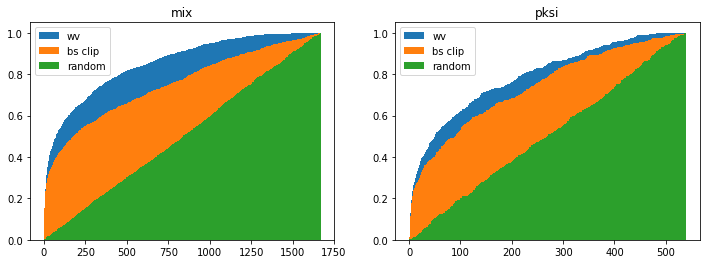

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax1, ax2 = ax

ax1.set_title('mix')
ax1.hist(data_mix_wv, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='wv')
ax1.hist(data_mix_bs, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='bs clip')
ax1.hist(rand_mix_bs, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='random')
ax1.legend()

ax2.set_title('pksi')
ax2.hist(data_pksi_wv, cumulative=True, bins=max_rank, range=[0, max_rank_pksi], density=True, label='wv')
ax2.hist(data_pksi_bs, cumulative=True, bins=max_rank, range=[0, max_rank_pksi], density=True, label='bs clip')
ax2.hist(rand_pksi_bs, cumulative=True, bins=max_rank, range=[0, max_rank_pksi], density=True, label='random')
ax2.legend()

plt.show()

In [119]:
import seaborn as sns
sns.set()

In [126]:
data_nrps_wv, rand_nrps_wv = iokr_results_3[('NRPS', 'pfam_wv')]
data_nrps_bs, rand_nrps_bs = iokr_results_3[('NRPS', 'bigscape_clip')]
max_rank_nrps = max(data_nrps_wv + rand_nrps_wv)


In [129]:
import pickle
with open('bgc_mibig_iokr_plot_data.bin', 'wb') as f:
    pickle.dump((data_mix_wv, data_mix_bs, rand_mix_bs, max_rank, data_nrps_wv, data_nrps_bs, rand_nrps_bs, max_rank_nrps, max_rank_mix), f)



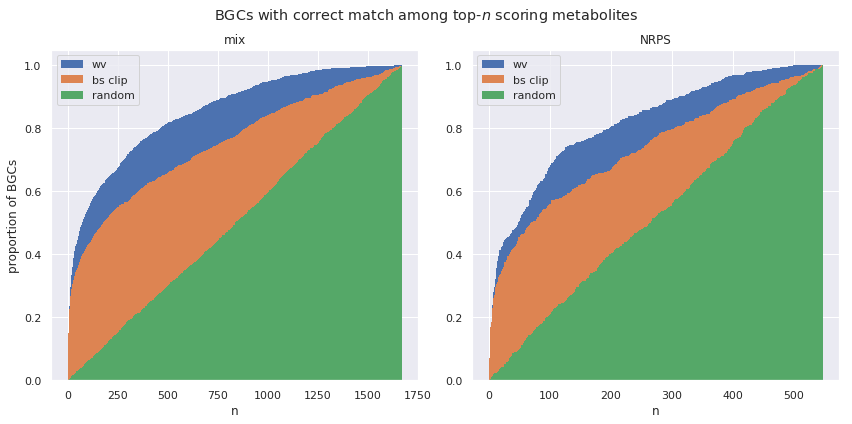

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('BGCs with correct match among top-$n$ scoring metabolites')

ax1, ax2 = ax

ax1.set_title('mix')
ax1.hist(data_mix_wv, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='wv',  linewidth=0)
ax1.hist(data_mix_bs, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='bs clip',  linewidth=0)
ax1.hist(rand_mix_bs, cumulative=True, bins=max_rank, range=[0, max_rank_mix], density=True, label='random',  linewidth=0)
ax1.set_ylabel('proportion of BGCs')
ax1.set_xlabel('n')
ax1.legend()

ax2.set_title('NRPS')
ax2.hist(data_nrps_wv, cumulative=True, bins=max_rank, range=[0, max_rank_nrps], density=True, label='wv',  linewidth=0)
ax2.hist(data_nrps_bs, cumulative=True, bins=max_rank, range=[0, max_rank_nrps], density=True, label='bs clip',  linewidth=0)
ax2.hist(rand_nrps_bs, cumulative=True, bins=max_rank, range=[0, max_rank_nrps], density=True, label='random',  linewidth=0)
ax2.set_xlabel('n')
ax2.legend()

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.savefig('bgc_mibig_auc_plot_mix_nrps.pdf')
plt.show()

In [114]:
n = 0
prod_res = {}
col_order = []
for k, v in iokr_results_3.items():
    prod, kern = k
    if kern.startswith('bigscape_reconstructed'):
        continue
    if kern not in col_order:
        col_order.append(kern)
    data, rand = v
    top_n_data = len([x for x in data if x <= n]) / len(data)
    top_n_rand = len([x for x in rand if x <= n]) / len(rand)
    #print(prod, kern, top_n_data, top_n_rand)
    if prod in prod_res:
        prod_res[prod].append(top_n_data)
    else:
        prod_res[prod] = [top_n_data]
        
print(' & '.join(col_order))
for prod, col in prod_res.items():
    print(prod, end=' & ')
    for num in col:
        print("{:.03f}".format(num), end=' & ')
    print()
    

bigscape & bigscape_clip & bigscape_flip & pfam_wv & tfidf_wv & bigscape_uncalibrated_clip & bigscape_recalibrated_clip & bigscape_uncalibrated_flip & bigscape_recalibrated_flip
NRPS & 0.002 & 0.013 & 0.004 & 0.005 & 0.004 & 0.009 & 0.002 & 0.009 & 0.002 & 
Others & 0.002 & 0.004 & 0.008 & 0.004 & 0.006 & 0.012 & 0.004 & 0.008 & 0.004 & 
PKSI & 0.000 & 0.011 & 0.004 & 0.015 & 0.013 & 0.011 & 0.013 & 0.009 & 0.000 & 
PKS-NRP_Hybrids & 0.000 & 0.004 & 0.004 & 0.004 & 0.000 & 0.004 & 0.004 & 0.004 & 0.004 & 
PKSother & 0.000 & 0.003 & 0.000 & 0.003 & 0.003 & 0.000 & 0.003 & 0.000 & 0.000 & 
RiPPs & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 
Saccharides & 0.000 & 0.000 & 0.015 & 0.015 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 & 
Terpene & 0.000 & 0.013 & 0.000 & 0.013 & 0.000 & 0.006 & 0.006 & 0.006 & 0.013 & 
mix & 0.002 & 0.013 & 0.004 & 0.008 & 0.005 & 0.009 & 0.010 & 0.006 & 0.001 & 


In [115]:
n = 4
prod_res = {}
col_order = []
for k, v in iokr_results_3.items():
    prod, kern = k
    if kern.startswith('bigscape_reconstructed'):
        continue
    if kern not in col_order:
        col_order.append(kern)
    data, rand = v
    top_n_data = len([x for x in data if x <= n]) / len(data)
    top_n_rand = len([x for x in rand if x <= n]) / len(rand)
    #print(prod, kern, top_n_data, top_n_rand)
    if prod in prod_res:
        prod_res[prod].append(top_n_data)
    else:
        prod_res[prod] = [top_n_data]
        
print(' & '.join(col_order))
for prod, col in prod_res.items():
    print(prod, end=' & ')
    for num in col:
        print("{:.03f}".format(num), end=' & ')
    print()

bigscape & bigscape_clip & bigscape_flip & pfam_wv & tfidf_wv & bigscape_uncalibrated_clip & bigscape_recalibrated_clip & bigscape_uncalibrated_flip & bigscape_recalibrated_flip
NRPS & 0.031 & 0.186 & 0.084 & 0.184 & 0.173 & 0.157 & 0.159 & 0.157 & 0.033 & 
Others & 0.064 & 0.153 & 0.085 & 0.137 & 0.147 & 0.145 & 0.145 & 0.145 & 0.048 & 
PKSI & 0.002 & 0.176 & 0.067 & 0.191 & 0.194 & 0.165 & 0.169 & 0.135 & 0.022 & 
PKS-NRP_Hybrids & 0.046 & 0.212 & 0.108 & 0.229 & 0.233 & 0.192 & 0.204 & 0.192 & 0.058 & 
PKSother & 0.048 & 0.168 & 0.082 & 0.175 & 0.148 & 0.134 & 0.148 & 0.134 & 0.045 & 
RiPPs & 0.268 & 0.408 & 0.268 & 0.352 & 0.423 & 0.437 & 0.380 & 0.394 & 0.155 & 
Saccharides & 0.388 & 0.403 & 0.358 & 0.388 & 0.358 & 0.358 & 0.418 & 0.358 & 0.164 & 
Terpene & 0.051 & 0.083 & 0.038 & 0.083 & 0.109 & 0.071 & 0.077 & 0.058 & 0.019 & 
mix & 0.016 & 0.169 & 0.077 & 0.160 & 0.156 & 0.155 & 0.151 & 0.124 & 0.039 & 


In [116]:
n = 19
prod_res = {}
col_order = []
for k, v in iokr_results_3.items():
    prod, kern = k
    if kern.startswith('bigscape_reconstructed'):
        continue
    if kern not in col_order:
        col_order.append(kern)
    data, rand = v
    top_n_data = len([x for x in data if x <= n]) / len(data)
    top_n_rand = len([x for x in rand if x <= n]) / len(rand)
    #print(prod, kern, top_n_data, top_n_rand)
    if prod in prod_res:
        prod_res[prod].append(top_n_data)
    else:
        prod_res[prod] = [top_n_data]
        
print(' & '.join(col_order))
for prod, col in prod_res.items():
    print(prod, end=' & ')
    for num in col:
        print("{:.03f}".format(num), end=' & ')
    print()

bigscape & bigscape_clip & bigscape_flip & pfam_wv & tfidf_wv & bigscape_uncalibrated_clip & bigscape_recalibrated_clip & bigscape_uncalibrated_flip & bigscape_recalibrated_flip
NRPS & 0.088 & 0.338 & 0.234 & 0.414 & 0.365 & 0.308 & 0.308 & 0.308 & 0.115 & 
Others & 0.128 & 0.263 & 0.209 & 0.333 & 0.337 & 0.242 & 0.255 & 0.251 & 0.147 & 
PKSI & 0.041 & 0.296 & 0.169 & 0.357 & 0.365 & 0.302 & 0.306 & 0.252 & 0.085 & 
PKS-NRP_Hybrids & 0.146 & 0.400 & 0.296 & 0.479 & 0.446 & 0.367 & 0.362 & 0.367 & 0.204 & 
PKSother & 0.127 & 0.326 & 0.210 & 0.447 & 0.467 & 0.278 & 0.278 & 0.278 & 0.220 & 
RiPPs & 0.549 & 0.676 & 0.648 & 0.634 & 0.690 & 0.761 & 0.789 & 0.817 & 0.690 & 
Saccharides & 0.597 & 0.582 & 0.567 & 0.597 & 0.612 & 0.657 & 0.731 & 0.657 & 0.478 & 
Terpene & 0.154 & 0.224 & 0.167 & 0.263 & 0.340 & 0.231 & 0.224 & 0.173 & 0.128 & 
mix & 0.045 & 0.291 & 0.184 & 0.344 & 0.336 & 0.275 & 0.272 & 0.246 & 0.121 & 
